In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import os
%matplotlib inline

## Track data: Features and Age Ratings

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

valence :
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [2]:
data = pd.read_csv('../data/all.csv')

In [3]:
print (data.columns)
print (data.shape)


Index(['Age', 'Album_Name', 'Artist', 'Year', 'Description', 'Age Group',
       'Album_ID', 'Album_Name_Spotify', 'Artists_Spotify', 'Track_ID', 'ISRC',
       'Track_Name', 'Artists', 'popularity', 'preview_url', 'image_url',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'lyrics'],
      dtype='object')
(19560, 34)


In [68]:

song_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', \
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', \
                'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']

columns = ['key','mode', 'time_signature', 'duration_min','popularity', 'danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

data['duration_min'] = data['duration_ms']/10**3/60

data = data.dropna(subset=columns)
data = data.astype({'key': 'Int64', 'mode':'Int64', 'time_signature':'Int64'})


X = data[columns]
y = list(data['Age'])

In [69]:
display(X.sample(5))

print ("Number of Tracks:" , X.shape[0])
print ("Number of Freatures:", X.shape[1])
print ("Ages: ", set(y))

,key,mode,time_signature,duration_min,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
9468,4,0,4,3.966883,28,0.739,0.607,-9.097,0.2510,0.0113,0.000373,0.0411,0.255,180.079
10686,2,1,4,3.284667,32,0.746,0.434,-9.391,0.0349,0.2990,0.002540,0.1710,0.713,113.514
2826,1,1,4,3.859117,1,0.415,0.162,-19.924,0.0332,0.9180,0.000244,0.1180,0.557,167.779
646,2,1,4,0.892000,20,0.717,0.275,-18.076,0.7390,0.7390,0.000000,0.5960,0.772,95.134
15209,0,1,4,2.659117,30,0.496,0.257,-14.559,0.0295,0.4520,0.000060,0.0411,0.460,127.475


Number of Tracks: 19527
Number of Freatures: 14
Ages:  {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


## Decision Tree Model

In [71]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


categorical_columns = ['key','mode', 'time_signature']

numeric_columns = ['duration_min','popularity', 'danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

features = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numeric_columns)
])

est = Pipeline([
    ('features', features),
    ('regressor', DecisionTreeRegressor(max_depth=5) )
])

est.fit(X_train, y_train)


print ("R^2 Score: ", est.score(X_test,y_test))


# The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a  score of 0.0."

R^2 Score:  0.5021094761704463


In [72]:
from sklearn.metrics import mean_squared_error
import math
test_error = math.sqrt(mean_squared_error(y_test, est.predict(X_test)))

mean = np.mean(y_train)
baseline_error  = math.sqrt(mean_squared_error(y_test, [mean for _ in range(len(y_test))]))

print ("Base Line Model Test Error: ", baseline_error)
print ("Current Model Test Error: ", test_error)

Base Line Model Test Error:  4.825135424997403
Current Model Test Error:  3.4046751211576454


## Cross validation on  max_depth 

In [74]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


categorical_columns = ['key','mode', 'time_signature']

numeric_columns = ['duration_min','popularity', 'danceability', 'energy','loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

features = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numeric_columns)
])


pipeline = Pipeline([
    ('features', features),
    ('regressor', DecisionTreeRegressor()) 
])
param_grid = {'regressor__max_depth': range(2,10)}
est = GridSearchCV(pipeline,  param_grid,  return_train_score = True)
est.fit(X_train, y_train);

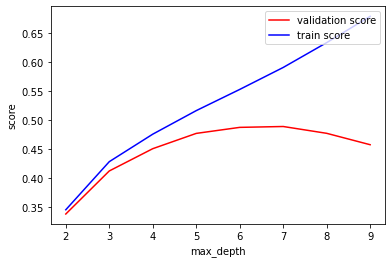

In [75]:
depth = est.param_grid['regressor__max_depth']

plt.plot(depth, est.cv_results_['mean_test_score'], c='r', label = 'validation score')
plt.plot(depth, est.cv_results_['mean_train_score'], c='b', label = 'train score')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend(loc='upper right');

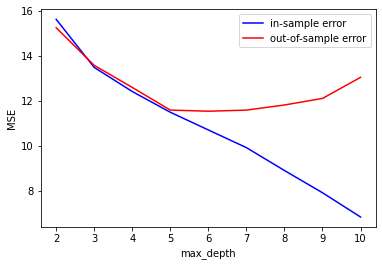

In [76]:

from sklearn import metrics
test_errors = []
in_sample_errors = []
max_depths= [2,3,4,5,6,7,8,9,10]
for max_depth in max_depths:
    model = DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    in_sample_errors.append(metrics.mean_squared_error(y_train, y_train_pred))
    test_errors.append(metrics.mean_squared_error(y_test, y_pred))

plt.plot(max_depths, in_sample_errors, 'b-', label='in-sample error')
plt.plot(max_depths, test_errors, c='r', label='out-of-sample error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

## Feature importance

In [77]:
model = est.best_estimator_['regressor']
model.feature_importances_

array([3.93365795e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.52453163e-04, 0.00000000e+00, 0.00000000e+00, 1.39259028e-05,
       5.32339918e-04, 2.57183169e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24844732e-03, 8.33877420e-04, 2.21047840e-01,
       4.86270687e-01, 1.02270756e-02, 6.85148633e-03, 2.57850521e-02,
       1.01199199e-01, 8.88606949e-02, 8.16689462e-03, 7.46119806e-03,
       3.30803263e-02, 5.10330518e-03])

In [78]:
est.best_estimator_['features'].get_feature_names()[0:10]

['categorical__x0_0',
 'categorical__x0_1',
 'categorical__x0_2',
 'categorical__x0_3',
 'categorical__x0_4',
 'categorical__x0_5',
 'categorical__x0_6',
 'categorical__x0_7',
 'categorical__x0_8',
 'categorical__x0_9']

In [63]:
feature_names = est.best_estimator_['features'].get_feature_names()
features = [(feature_names[i], model.feature_importances_[i]) for i in range(len(feature_names))]

for feature in sorted(features, key=lambda x: -x[1]):
    print (feature)

('popularity', 0.48695586683099706)
('duration_ms', 0.22108574948959803)
('speechiness', 0.10207091686662674)
('acousticness', 0.08884398380442976)
('valence', 0.03304241685961839)
('loudness', 0.025781802675881312)
('danceability', 0.010243786703616484)
('instrumentalness', 0.008166894620060507)
('liveness', 0.00746119805922366)
('energy', 0.0068547357065220586)
('tempo', 0.003953698869950373)
('categorical__x1_0', 0.00310417161183368)
('categorical__x2_4', 0.0012484473189348466)
('categorical__x2_5', 0.0008338774197275185)
('categorical__x0_8', 0.0003524531629795962)
('categorical__x0_0', 0.0)
('categorical__x0_1', 0.0)
('categorical__x0_2', 0.0)
('categorical__x0_3', 0.0)
('categorical__x0_4', 0.0)
('categorical__x0_5', 0.0)
('categorical__x0_6', 0.0)
('categorical__x0_7', 0.0)
('categorical__x0_9', 0.0)
('categorical__x0_10', 0.0)
('categorical__x0_11', 0.0)
('categorical__x1_1', 0.0)
('categorical__x2_0', 0.0)
('categorical__x2_1', 0.0)
('categorical__x2_3', 0.0)


## Visualize the decision tree

### Problem with Graphviz on win10
https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

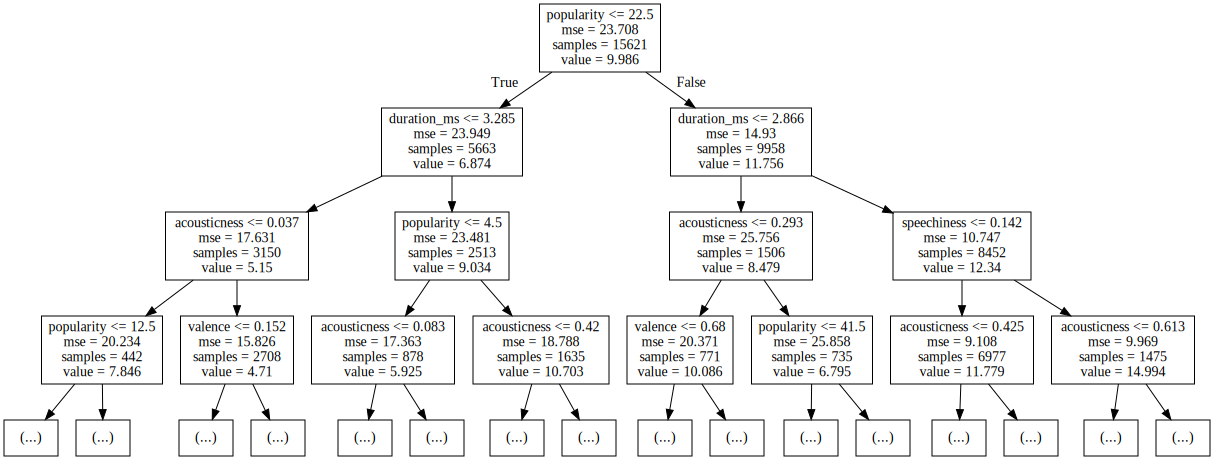

In [79]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


import graphviz
from sklearn.tree import export_graphviz
g = graphviz.Source(export_graphviz(model, feature_names=feature_names, max_depth=3))
g

In [80]:
g.render('../figures/rating_decision_tree', format='png')

'..\\figures\\rating_decision_tree.png'